In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as stattools
import statsmodels.tsa.ardl as ardl
import math

import lead_lag as ll

In [2]:
df = pd.read_csv("../prices.txt", sep='\s+', header=None, index_col=None)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,13.845620,69.033740,47.262580,48.004780,55.496120,11.740700,18.177200,46.78280,68.537300,50.185100,...,31.651400,63.251640,12.502360,60.843540,36.523580,52.461460,57.537160,34.427360,41.273040,56.123620
std,0.748745,3.908187,0.614438,2.051494,1.733916,0.635884,0.299771,1.26656,0.585843,3.207362,...,0.771223,7.833634,0.940225,1.898022,1.561982,0.756214,4.548284,0.878169,3.814908,1.178059
min,12.630000,62.470000,46.330000,44.900000,51.660000,10.020000,17.650000,44.01000,67.260000,45.260000,...,30.270000,50.620000,10.630000,56.260000,31.760000,50.210000,49.200000,32.800000,31.640000,53.470000
25%,13.207500,65.517500,46.820000,45.750000,54.000000,11.480000,17.970000,45.91750,68.110000,47.597500,...,30.950000,55.865000,11.817500,59.420000,35.837500,52.050000,54.062500,33.800000,39.615000,55.317500
50%,13.590000,68.255000,46.975000,47.830000,55.880000,11.850000,18.100000,46.69000,68.550000,49.535000,...,31.590000,64.615000,12.210000,60.750000,36.825000,52.375000,55.425000,34.350000,41.665000,56.100000
75%,14.582500,72.915000,47.800000,50.380000,56.720000,12.210000,18.410000,47.50250,68.912500,52.192500,...,32.302500,70.352500,13.232500,62.107500,37.602500,52.892500,61.855000,35.032500,43.525000,57.002500
max,15.560000,75.150000,48.610000,51.010000,59.120000,13.000000,18.980000,51.09000,69.990000,59.100000,...,33.260000,77.470000,14.500000,66.090000,39.130000,54.150000,66.600000,36.480000,50.020000,59.310000


In [4]:
# Check if stationary
# Non-stationary
def test_stationary(series):
    print("Results of Dickey-Fuller Test:")
    dftest = stattools.adfuller(series, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    print("Results of KPSS Test:")
    kpsstest = stattools.kpss(series, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

test_stationary(df[8])

Results of Dickey-Fuller Test:
Test Statistic                  -2.613868
p-value                          0.090165
#Lags Used                       2.000000
Number of Observations Used    497.000000
Critical Value (1%)             -3.443576
Critical Value (5%)             -2.867373
Critical Value (10%)            -2.569877
dtype: float64
Results of KPSS Test:
Test Statistic            0.665248
p-value                   0.016705
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [5]:
# Best order for ARIMA: (2, 1, 1)
model8 = sm.tsa.arima.ARIMA(endog=(df[8] - df[8].mean()), order=(2, 1, 1))
res8 = model8.fit()
print(res8.summary())

res8.save("../model8.pickle")

                               SARIMAX Results                                
Dep. Variable:                      8   No. Observations:                  500
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 447.039
Date:                Fri, 28 Jun 2024   AIC                           -886.078
Time:                        20:53:51   BIC                           -869.228
Sample:                             0   HQIC                          -879.466
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6735      0.145     -4.638      0.000      -0.958      -0.389
ar.L2          0.1572      0.048      3.294      0.001       0.064       0.251
ma.L1          0.7773      0.142      5.466      0.0

In [ ]:
res8 = sm.load("../arima_model/model8.pickle")
applied8 = res8.apply(df[8][1:111] - df[8].mean())
print(applied8.forecast(1).values[1] + df[8].mean(), df[8][111])

67.85658536284753 67.69


In [6]:
print(res8.resid)
print(res8.resid[1:].mean())
print(res8.resid[1:].std())
print(res8.resid[1:].max())

0      0.952700
1      0.240000
2     -0.153814
3     -0.067659
4      0.172100
         ...   
495    0.061481
496    0.034413
497   -0.105526
498    0.095125
499    0.024082
Length: 500, dtype: float64
-0.0007179878632538049
0.09889691523636979
0.33614225197037406


In [7]:
test_stationary(res8.resid)

Results of Dickey-Fuller Test:
Test Statistic                 -23.405139
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    499.000000
Critical Value (1%)             -3.443523
Critical Value (5%)             -2.867350
Critical Value (10%)            -2.569864
dtype: float64
Results of KPSS Test:
Test Statistic           0.043741
p-value                  0.100000
Lags Used                1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Users\DELL\AppData\Local\Temp\ipykernel_19464\61105336.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = stattools.kpss(series, regression="c", nlags="auto")


In [8]:
print(df[8])
priceChange = np.array(df[8])[1:] - np.array(df[8])[:-1]

print(priceChange)
print(priceChange.mean())

print(priceChange.std())

0      69.49
1      69.73
2      69.60
3      69.54
4      69.68
       ...  
495    69.00
496    69.04
497    68.95
498    69.03
499    69.06
Name: 8, Length: 500, dtype: float64
[ 0.24 -0.13 -0.06  0.14  0.13 -0.05  0.   -0.12 -0.11 -0.12 -0.04  0.01
 -0.19 -0.1  -0.03 -0.12 -0.06 -0.15 -0.18 -0.01  0.15  0.09 -0.03  0.02
  0.01  0.1   0.05 -0.2  -0.09  0.08  0.13  0.12 -0.07  0.    0.    0.02
 -0.04 -0.15 -0.04  0.08  0.05 -0.07 -0.11 -0.08  0.04  0.02 -0.08  0.18
 -0.21  0.11  0.06  0.17  0.06 -0.01 -0.05 -0.04 -0.07 -0.06  0.01  0.02
  0.07  0.12 -0.04 -0.13  0.03 -0.12  0.06 -0.06 -0.15 -0.07 -0.04 -0.05
 -0.04  0.04 -0.01 -0.07 -0.06  0.03 -0.03  0.02 -0.1  -0.14 -0.06  0.12
  0.17  0.11 -0.11  0.08 -0.02  0.07 -0.18  0.09 -0.01 -0.05 -0.03 -0.09
  0.07 -0.18 -0.07 -0.19 -0.18 -0.01  0.04 -0.1  -0.14  0.03  0.19  0.07
  0.23  0.06  0.02  0.2   0.01 -0.04 -0.04  0.16 -0.07 -0.02  0.04  0.09
  0.12 -0.03  0.07  0.08 -0.04  0.03  0.02 -0.17 -0.07  0.04 -0.03  0.07
  0.07  0.13  0.1

0.9069515239547417


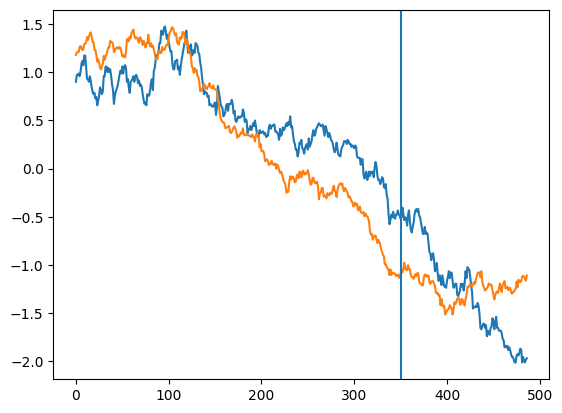

In [39]:
# Check for lead lags
# (18, 3): Not accurate enough
# 

share1 = 18
share2 = 3
lag = 13

standard1 = (df[share1] - df[share1].mean())/ df[share1].std()
standard2 = (df[share2] - df[share2].mean())/ df[share2].std()
shifted1 = pd.Series(np.array(standard1)[:-lag])
shifted2 = pd.Series(np.array(standard2)[lag:])

print(shifted1.corr(shifted2))

sns.lineplot(shifted1)
sns.lineplot(shifted2)
plt.axvline(350)


<Axes: ylabel='18'>

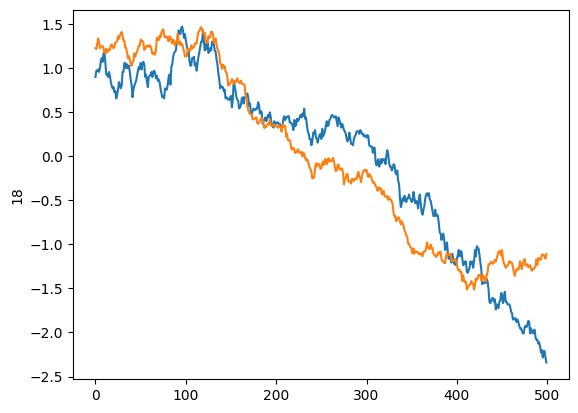

In [40]:
sns.lineplot(standard1)
sns.lineplot(standard2)

In [82]:
print(df[8])
print(df[8].shift(2).dropna().values)
print(df[8])

0      69.49
1      69.73
2      69.60
3      69.54
4      69.68
       ...  
495    69.00
496    69.04
497    68.95
498    69.03
499    69.06
Name: 8, Length: 500, dtype: float64
[69.49 69.73 69.6  69.54 69.68 69.81 69.76 69.76 69.64 69.53 69.41 69.37
 69.38 69.19 69.09 69.06 68.94 68.88 68.73 68.55 68.54 68.69 68.78 68.75
 68.77 68.78 68.88 68.93 68.73 68.64 68.72 68.85 68.97 68.9  68.9  68.9
 68.92 68.88 68.73 68.69 68.77 68.82 68.75 68.64 68.56 68.6  68.62 68.54
 68.72 68.51 68.62 68.68 68.85 68.91 68.9  68.85 68.81 68.74 68.68 68.69
 68.71 68.78 68.9  68.86 68.73 68.76 68.64 68.7  68.64 68.49 68.42 68.38
 68.33 68.29 68.33 68.32 68.25 68.19 68.22 68.19 68.21 68.11 67.97 67.91
 68.03 68.2  68.31 68.2  68.28 68.26 68.33 68.15 68.24 68.23 68.18 68.15
 68.06 68.13 67.95 67.88 67.69 67.51 67.5  67.54 67.44 67.3  67.33 67.52
 67.59 67.82 67.88 67.9  68.1  68.11 68.07 68.03 68.19 68.12 68.1  68.14
 68.23 68.35 68.32 68.39 68.47 68.43 68.46 68.48 68.31 68.24 68.28 68.25
 68.32 68.39 68.52

In [108]:
# Predict function for lead lag
def predict_next(df, ticker, indices, lags, shift, currentPoint):
    matchedSeries = df[indices].pct_change().dropna().values
    if len(indices) > 1:
        matchedSeries = matchedSeries[currentPoint-shift-199:currentPoint-shift+1, :]
    else:
        matchedSeries = matchedSeries[currentPoint-shift-199:currentPoint-shift+1]
    
    predictSeries = df[ticker].pct_change().dropna().values[currentPoint-199:currentPoint+1]
    # print(matchedSeries.shape)
    # print(len(predictSeries))

    result = ardl.ARDL(
        predictSeries,
        0,
        matchedSeries,
        lags,
        causal=True
    ).fit()

    predict_val = result.forecast()
    # print(predict_mu)
    return predict_val

49.225783132530125 0.25402305179525225
-0.000556974720609303 0.04455116365974526
MSE error 0.059679238551858305
MSE error change 0.0009030856195662571


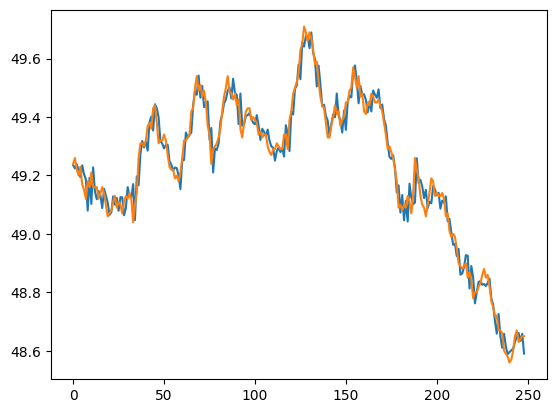

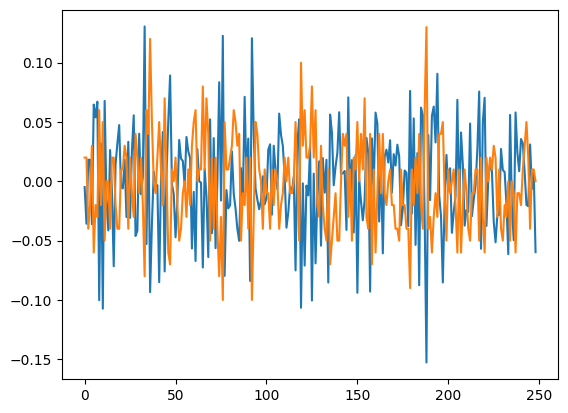

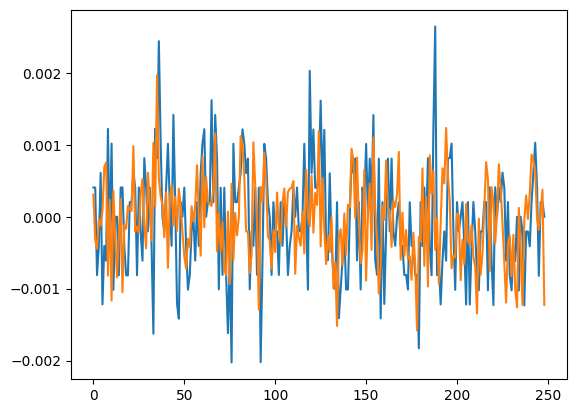

In [112]:
predictValues = []
errors = []
actuals = []

price_changes = []
error_changes = []

actual_changes = []
predict_changes = []

sharePredict = 39
indices = list(range(50))
shift = 0
lags = 1
for i in range(250, 499):
    actual_change = ((df[sharePredict][i + 1] - df[sharePredict][i])/df[sharePredict][i])
    predict_change = predict_next(df, sharePredict, indices, lags, shift, i)[-1]
    predict = df[sharePredict][i] * (1 + predict_change)
    actual = df[sharePredict][i+1]
    error = predict - actual

    price_changes.append(((df[sharePredict][i + 1] - df[sharePredict][i])))
    error_changes.append(predict_change - actual_change)
    errors.append(error)
    actuals.append(actual)
    predictValues.append(predict)
    actual_changes.append(actual_change)
    predict_changes.append(predict_change)

actuals = pd.Series(actuals)
errors = pd.Series(errors)
error_changes = pd.Series(error_changes)
print(actuals.mean(), actuals.std())
print(errors.mean(), errors.std())
print("MSE error", math.sqrt((error * error).mean()))
mse_error_change = math.sqrt((error_changes * error_changes).mean())
print("MSE error change", mse_error_change)


sns.lineplot(predictValues)
sns.lineplot(actuals)

plt.figure()
plt.plot(errors)
plt.plot(price_changes)

plt.figure()
plt.plot(actual_changes)
plt.plot(predict_changes)

In [109]:
potential = []
for j in range(50):
    print("Ticker: ", i)
    predictValues = []
    errors = []
    actuals = []

    price_changes = []
    error_changes = []

    actual_changes = []
    predict_changes = []

    sharePredict = i
    indices = list(range(50))
    shift = 0
    lags = 1
    for i in range(250, 499):
        actual_change = ((df[sharePredict][i + 1] - df[sharePredict][i])/df[sharePredict][i])
        predict_change = predict_next(df, sharePredict, indices, lags, shift, i)[-1]
        predict = df[sharePredict][i] * (1 + predict_change)
        actual = df[sharePredict][i+1]
        error = predict - actual

        price_changes.append(((df[sharePredict][i + 1] - df[sharePredict][i])))
        error_changes.append(predict_change - actual_change)
        errors.append(error)
        actuals.append(actual)
        predictValues.append(predict)
        actual_changes.append(actual_change)
        predict_changes.append(predict_change)

    actuals = pd.Series(actuals)
    errors = pd.Series(errors)
    error_changes = pd.Series(error_changes)
    print(actuals.mean(), actuals.std())
    print(errors.mean(), errors.std())
    print("MSE error", math.sqrt((error * error).mean()))
    mse_error_change = math.sqrt((error_changes * error_changes).mean())
    print("MSE error change", mse_error_change)

    if (mse_error_change < 0.002):
        potential.append((j, mse_error_change))

    # sns.lineplot(predictValues)
    # sns.lineplot(actuals)

    # plt.figure()
    # plt.plot(errors)
    # plt.plot(price_changes)

    # plt.figure()
    # plt.plot(actual_changes)
    # plt.plot(predict_changes)

Ticker:  0
13.493734939759038 0.5102095810121059
0.0023707430128052324 0.10154026686171312
MSE error 0.19987820660160516
MSE error change 0.007464024218487319
Ticker:  1
65.53489959839357 1.8474302362422501
-0.03355857547572596 0.46358881523271944
MSE error 0.10165060640677837
MSE error change 0.007080243006971333
Ticker:  2
46.77570281124497 0.18508173878691433
-0.003971620087552073 0.0409574950725128
MSE error 0.03398556897803928
MSE error change 0.0008783679163561521
Ticker:  3
46.208112449799195 0.9503802567737533
-0.006416971567235386 0.09313036238522451
MSE error 0.15889840093417007
MSE error change 0.002016895197631673
Ticker:  4
55.900361445783126 1.952393968321926
0.025197434547139127 0.27057166167305746
MSE error 0.1480848326222315
MSE error change 0.004840571996743139
Ticker:  5
11.460923694779115 0.7092780505732595
0.0023653717678843093 0.0751564765361383
MSE error 0.11348294814788851
MSE error change 0.0065435063642639586
Ticker:  6
18.0325702811245 0.24066402611953827
-0.

In [110]:
potential

[498, 498, 498, 498, 498, 498, 498]

In [90]:
print(len(df[8]))
print(len(df[8].pct_change()))
print(len(df.values))

500
500
500
